In [11]:
from prelim import do_prelim_on_single_feature
from pymongo.mongo_client import MongoClient
from pymongo.server_api import ServerApi
import numpy as np
from matplotlib import pyplot as plt
import itertools
from scipy.spatial import ConvexHull, convex_hull_plot_2d
from shapely.geometry import Polygon
from scipy import spatial
import alphashape
import requests
import json

In [3]:
uri = "localhost:27017"
client = MongoClient(uri, server_api=ServerApi('1'))

client.admin.command('ping')

{'ok': 1.0}

In [4]:
db = client.test
historical_evolution_data = db.historicalEvolutionData
problem_instances = db.probleminstances
db_prelim_information = db.prelimInformation

In [29]:
experiment_id = "27-09-1000"

transformed_projection_matrix_values = {
        "totalPassengerCount":[-0.3960,-0.3227],
        "passengerRatio":[0.1701,-0.6613],
        "totalCongestion":[0.4294,-0.7562],
        "blockedPassengerRatio":[-0.3783,-0.1508],
        "conflictFreePassengerSeatingRatio":[0.7470,0.3224]
}

x_plot_lim = [-5, 4]
y_plot_lim = [-6, 5]

likely_border = [
[-0.930918238683993,-3.98302995127808],
[1.53689913375061,-2.91803891677161],
[3.71308700286112,-1.14492369879520],
[2.97512568832687,1.72424892180437],
[1.51713523168341,4.29180389059854],
[0.0614017557687737,3.71158833360980],
[-2.40641561666583,2.64659729910332],
[-4.58260348577634,0.873482081126921],
[-3.84464217124209,-1.99569053947265],
[-2.38665171459863,-4.56324550826682],
[-0.930918238683993,-3.98302995127808],
]

generator_colors = {
    "SimpleGenerator" : "darkorange",
    "RealisticGenerator" : "blue",
    "LocalSearchController" : "green"
}

generators_alt_names = {
    "SimpleGenerator" : "mk_s",
    "RealisticGenerator" : "mk_r",
    "LocalSearchController" : "lokalesuche"
}

goodness_names = {
    True : "Gut",
    False : "Schlecht",
}

goodness_color = {
    True : "blue",
    False : "darkorange",
}

sorted_feature_names = sorted(transformed_projection_matrix_values.keys())
transformed_projection_matrix = []
for i in range(0, len(sorted_feature_names)):
    transformed_projection_matrix.append(transformed_projection_matrix_values[sorted_feature_names[i]])

projection_matrix = np.array(transformed_projection_matrix).transpose()

In [74]:
def get_instances_and_coordinates():
    prelim_information = db_prelim_information.find({"experimentId" : experiment_id})
    instances = problem_instances.find({"experimentId" : experiment_id})
    instance_feature_vectors = list(map(lambda x: (x, convert_instance_to_feature_vector(x, prelim_information[0])), instances))
    return list(map(lambda x: (x[0], convert_feature_vector_to_coordinates(x[1])), instance_feature_vectors))

def convert_instance_to_feature_vector(instance, prelim_data):
    feature_vector = {}
    for feature in prelim_data["prelimDataOfFeatures"].keys():
        feature_vector[feature] = do_prelim_on_single_feature(instance["featureDescription"][feature], prelim_data["prelimDataOfFeatures"][feature])
    return feature_vector

def convert_feature_vector_to_coordinates(feature_vector):
    sorted_features= sorted(feature_vector.keys())
    vector_array = []
    for i in range(0, len(sorted_features)):
        vector_array.append(feature_vector[sorted_features[i]])
    vector = np.array(vector_array)
    return np.matmul(projection_matrix, vector)

def visualize_instance_space(instance_coordinate_pairs, border_coords = [], original_instances_more_transparent = False,targets = [], algorithm = ""):
        instance_coordinate_pairs.sort(key = lambda x: x[2])
        grouped_instances_by_goodness = itertools.groupby(instance_coordinate_pairs, key= lambda x: x[2])
        for key, group in grouped_instances_by_goodness:
            alpha = 1.0
            if (original_instances_more_transparent and (key == "SimpleGenerator" or key == "RealisticGenerator")):
                alpha = 0.3

            group_list = list(group)
            x_coords = [pair[1][0] for pair in group_list]
            y_coords = [pair[1][1] for pair in group_list]

            plt.scatter(x_coords, y_coords, label=goodness_names[key], color=goodness_color[key], alpha = alpha, s = 1.6, zorder=2)
            
            #plt.scatter(instance_pair[1][0], instance_pair[1][1], label=goodness_names[instance_pair[2]], color=goodness_color[instance_pair[2]], alpha = alpha, s = 1.6, zorder=2)

        if (len(border_coords) > 0):
            xs, ys = zip(*border_coords)
            plt.plot(xs, ys, color='red',zorder=1)

        if (len(targets) > 0):
            xs, ys = zip(*targets)
            plt.scatter(xs, ys, color='black', marker = "s",s = 2)
    
        plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.10),ncol=2)
        ax = plt.gca()
        ax.set_axisbelow(True)
        plt.grid()
        plt.title("SVM Vorhersage für " + algorithm)
        plt.xlim(x_plot_lim)
        plt.xticks(np.arange(min(x_plot_lim), max(x_plot_lim), 1.0))
        plt.ylim(y_plot_lim)
        plt.yticks(np.arange(min(y_plot_lim), max(y_plot_lim), 1.0))

        plt.xlabel("$\mathregular{Z_1}$")
        plt.ylabel("$\mathregular{Z_2}$")
    
        plt.show()

def create_border_coordinates(border_values):
    prelim_information = db_prelim_information.find({"experimentId" : experiment_id})
    prelim_data = prelim_information[0]
    for feature in prelim_data["prelimDataOfFeatures"].keys():
        for border_point in border_values:
            border_point[feature] = do_prelim_on_single_feature(border_point[feature], prelim_data["prelimDataOfFeatures"][feature])
    return list(map(lambda x: convert_feature_vector_to_coordinates(x), border_values))

1000


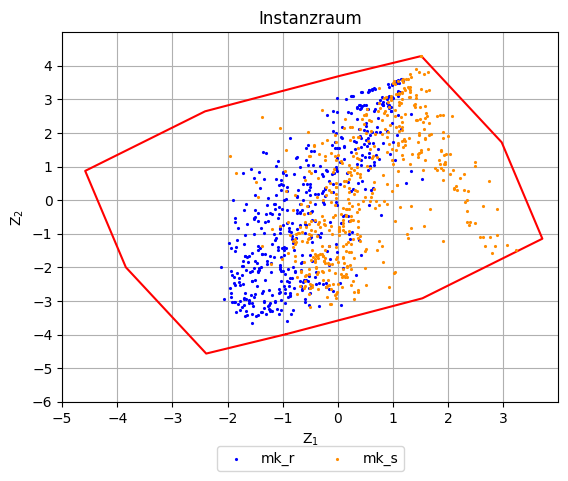

In [9]:
instances_and_coordinates = get_instances_and_coordinates()

instances_and_coordinates = instances_and_coordinates[:1000]

visualize_instance_space(instances_and_coordinates, border_coords = likely_border)

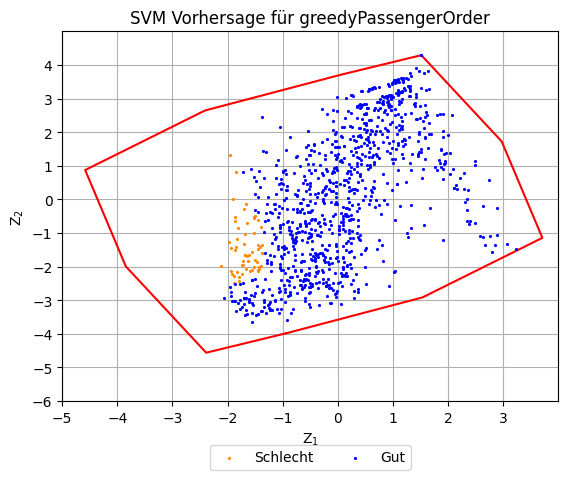

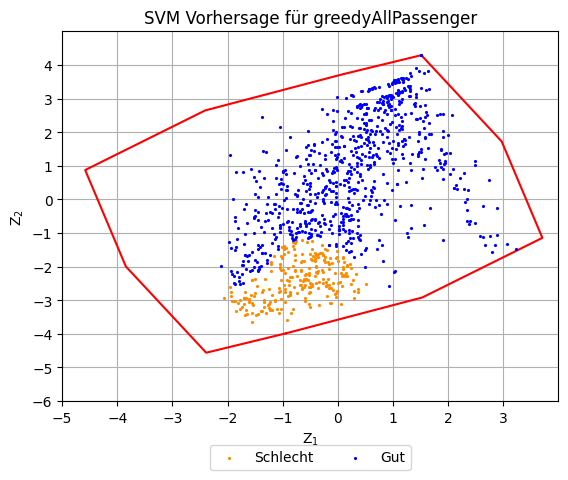

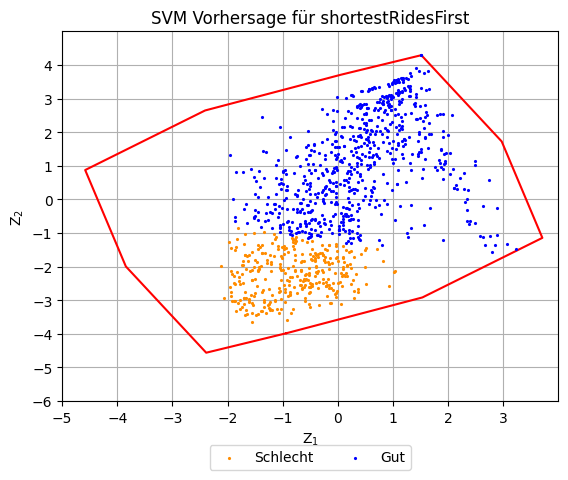

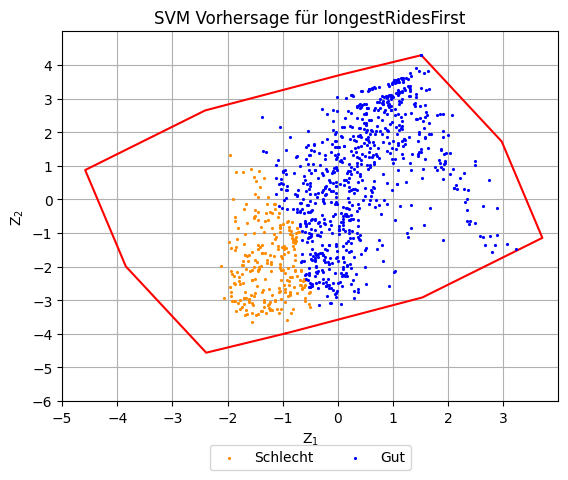

In [76]:
instances_and_coordinates = get_instances_and_coordinates()
instances_and_coordinates = instances_and_coordinates[:1000]

with open('pythia-results.json', 'r') as f:
    pythia_results = json.load(f)
f.close()

#right_sorting_order = instances_and_coordinates[500:] + instances_and_coordinates[:500]
#instances_and_coordinates = right_sorting_order

for algorithm in ["greedyPassengerOrder", "greedyAllPassenger", "shortestRidesFirst", "longestRidesFirst"]:
    
    instances_coordinates_goodness = []
    for i in range(0, len(instances_and_coordinates)):
        goodness = pythia_results[i][algorithm]
        instances_coordinates_goodness.append((instances_and_coordinates[i][0], instances_and_coordinates[i][1], goodness))

    #print(instances_coordinates_goodness[0][1]["instanceId"])
        
    visualize_instance_space(instances_coordinates_goodness, border_coords = likely_border, algorithm = algorithm)

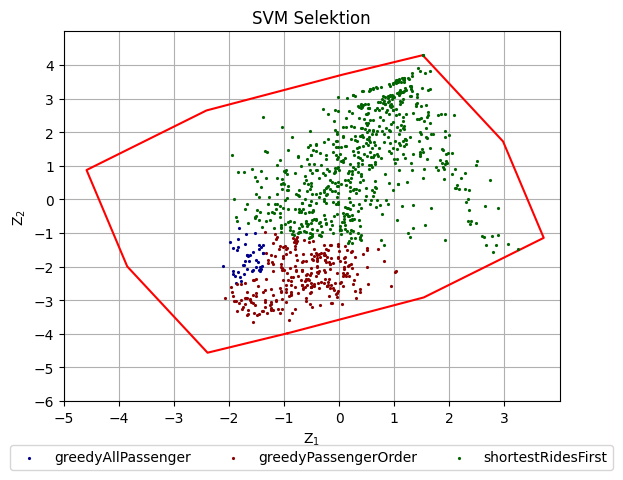

In [84]:
algorithm_colors = {
    "greedyPassengerOrder": "darkred",
    "greedyAllPassenger": "darkblue",
    "shortestRidesFirst": "darkgreen",
    "longestRidesFirst": "grey"
}


def visualize_algorithm_selection(instance_coordinate_pairs, border_coords = [], original_instances_more_transparent = False,targets = [], algorithm = ""):
        instance_coordinate_pairs.sort(key = lambda x: x[2])
        grouped_instances_by_goodness = itertools.groupby(instance_coordinate_pairs, key= lambda x: x[2])
        for key, group in grouped_instances_by_goodness:
            alpha = 1.0
            if (original_instances_more_transparent and (key == "SimpleGenerator" or key == "RealisticGenerator")):
                alpha = 0.3

            group_list = list(group)
            x_coords = [pair[1][0] for pair in group_list]
            y_coords = [pair[1][1] for pair in group_list]

            plt.scatter(x_coords, y_coords, label=key, color= algorithm_colors[key],  alpha = alpha, s = 1.6, zorder=2)
        
        if (len(border_coords) > 0):
            xs, ys = zip(*border_coords)
            plt.plot(xs, ys, color='red',zorder=1)

        if (len(targets) > 0):
            xs, ys = zip(*targets)
            plt.scatter(xs, ys, color='black', marker = "s",s = 2)
    
        plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.10),ncol=4)
        ax = plt.gca()
        ax.set_axisbelow(True)
        plt.grid()
        plt.title("SVM Selektion")
        plt.xlim(x_plot_lim)
        plt.xticks(np.arange(min(x_plot_lim), max(x_plot_lim), 1.0))
        plt.ylim(y_plot_lim)
        plt.yticks(np.arange(min(y_plot_lim), max(y_plot_lim), 1.0))

        plt.xlabel("$\mathregular{Z_1}$")
        plt.ylabel("$\mathregular{Z_2}$")
    
        plt.show()


with open('algorithmselection.json', 'r') as f:
    algorithm_selection = json.load(f)
f.close()

algorithms = ["greedyPassengerOrder", "greedyAllPassenger", "shortestRidesFirst", "longestRidesFirst"]

    
instances_coordinates_algorithms = []
for i in range(0, len(instances_and_coordinates)):
    algo = algorithms[algorithm_selection[i]["algorithm"] - 1]
    instances_coordinates_algorithms.append((instances_and_coordinates[i][0], instances_and_coordinates[i][1], algo))

visualize_algorithm_selection(instances_coordinates_algorithms, border_coords = likely_border)



In [97]:

with open('algorithmselection.json', 'r') as f:
    algorithm_selection = json.load(f)
f.close()

set(map(lambda x: x["algorithm"], algorithm_selection))

{1, 2, 3}